## AOS 575, Problem Set 4

Note to self: try upwind before piecewise linear method! Ensure tracers are conserved.


### Imports

In [232]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd # Only used for data statistics during debugging

In [233]:
%config InlineBackend.figure_format = 'svg'

### Problem 1

#### Definitions

Function for $u$ (horizontal component of velocity)

In [234]:
def u_x(x, y, t):
    ''' Define horizontal component of velocity. '''
    return (np.sin(np.pi*x)**2)*np.sin(2*np.pi*y)*np.cos(np.pi*t/5)

Function for $v$ (vertical component of velocity)

In [235]:
def u_y(x, y, t):
    ''' Define vertical component of velocity. '''
    return -np.sin(2*np.pi*x)*(np.sin(np.pi*y)**2)*np.cos(np.pi*t/5)

Function to select $r$ value at each grid point

In [236]:
def r_sel(c, v, print_bool=False):
    ''' Decide r value to use at each grid point given a constant and variable array. '''
    
    # Lengths in the horizontal (x) and vertical (y) directions
    l_x, l_y = c.shape[0], c.shape[1]
    # Initialize array for r
    r = np.full(shape=(l_x, l_y), fill_value=np.nan)
    # Iterate over each grid point
    for i in range(0, l_x):
        for j in range(0, l_y):
            # Print values
            print('x: {0:4d} | y: {1:4d} | C: {2:5.2f}, V:{3:5.2f}'.format(i, j, c[i, j], v[i, j])) if print_bool else None
            # Select lesser of both values
            r[i, j] = np.nanmin([c[i, j], v[i, j]])

    return r

Update staggered grid values based on current timestep

In [655]:
def regen(phi, X_stag, Y_stag):
    ''' Regenerate staggered grid values for fields that are functions of the velocity (rho, phi). '''
    
    # Define number of points in x and y, assuming same number of points in each direction
    ny, nx = phi.shape
    
    # Initialize fresh staggered grids
    phi_stag = np.full(shape=(ny-1, nx-1), fill_value=np.nan, dtype=float)
    
    # Iterate over points and average from surrounding points (average of 4 'surrounding' points)
    for i in range(1, ny):
        for j in range(1, nx):
            phi_stag[i-1, j-1] = np.mean([phi[i, j], phi[i, j-1], phi[i-1, j], phi[i-1, j-1]])
        
    return phi_stag

#### Implentation of numerical methods

__Spatial, first-order upwind advection__: Define a first-order upwind advection scheme to test basic functionality.

In [238]:
def fou_s(u, v, phi, dx):
    ''' First-order upwind advection scheme in space. '''
    
    # Assume equal grid spacing in x- and y-axes
    dy = dx
    
    # Initialize array holding differential values of u, v, and phi
    # Default value of 0 chosen to indicate no gradient
    d_u = np.full(shape=u.shape, fill_value=0, dtype=float)
    d_v = np.full(shape=v.shape, fill_value=0, dtype=float)
    d_phi_x = np.full(shape=phi.shape, fill_value=0, dtype=float)
    d_phi_y = np.full(shape=phi.shape, fill_value=0, dtype=float)
    
    # Index through all grid points (except for boundaries)
    # Assume u, v, and phi all have equivalent dimensions
    # Note: i corresponds to row (y-axis) and j corresponds to column (x-axis)
    for i in range(1, u.shape[0]):
        for j in range(1, u.shape[1]):
            # Print grid point and field values
            if print_bool:
                print('u[{0:2d}, {1:2d}]: {2:5.2f} | v[{0:2d}, {1:2d}]: {3:5.2f} | phi[{0:2d}, {1:2d}]: {4:5.2f}'.format(i, j, u[i, j], v[i, j], phi[i, j]))
             # Calculate differences
            d_u[i, j] = u[i, j] - u[i, j-1]
            d_v[i, j] = v[i, j] - v[i-1, j]
            d_phi_x[i, j] = phi[i, j] - phi[i, j-1]
            d_phi_y[i, j] = phi[i, j] - phi[i-1, j]
            
            # if print_bool:
            #     print('d_u[{0:2d}, {1:2d}]: {2:7.4f} | d_v[{0:2d}, {1:2d}]: {3:7.4f} | d_phi_x[{0:2d}, {1:2d}]: {4:7.4f}'.format(i, j, d_u[i, j], d_v[i, j], d_phi_x[i, j]))

    # Calculate field differential for use in the temporal scheme
    d_field = (1/dx)*(d_u*phi + d_phi_x*u) + (1/dy)*(d_v*phi + d_phi_y*v)
    
    return d_field

__Temporal, first-order upwind advection__: Define a first-order upwind advection scheme to test basic functionality.

In [164]:
def fou_t(u, v, phi, i, t, dt, dx):
    ''' First-order upwind advection scheme in time. '''
    
    # Define tracer concentrations for next timestep
    phi[:, :, i] = phi[:, :, i-1] - dt*fou_s(u[:, :, i-1], v[:, :, i-1], phi[:, :, i-1], dx)
    
    return phi

#### Model initialization
Initialize parameters for the model, grid, and data structures.

In [644]:
''' Define grid parameters. '''

x_min, x_max = [0, 1] # Horizontal domain limits
y_min, y_max = [0, 1] # Vertical domain limits
dx = 0.02 # Horizontal grid spacing
dy = dx # Vertical grid spacing

# Generate horizonal and vertical grid points
gp_x = np.arange(x_min, x_max+dx, dx) 
gp_y = np.arange(y_min, y_max+dy, dy) 
X, Y = np.meshgrid(gp_x, gp_y)

# Generate 1/2-point staggered grid
gp_x_stag = np.arange(x_min+(dx/2), x_max, dx) 
gp_y_stag = np.arange(x_min+(dx/2), x_max, dx) 
X_stag, Y_stag = np.meshgrid(gp_x_stag, gp_y_stag)

''' Define model parameters. '''

c = 0.5 # Courant number
dt = 0.5*dx # Note: maximum value of velocity field is 1
t_max = 5 # Maximum time
times = np.arange(0, t_max, dt) # Define time array

''' Initialize velocity field, tracer concentration, and density arrays. '''
# Note: the density array is included for Easter's pseudocompressibility method. As it is a 'pseudo-density', it will be set to be 1.

# Base grid: initiate 3-dimensional arrays dictated by (x, y, t)
u = np.full(shape=(len(gp_x), len(gp_y), len(times)), fill_value=np.nan)
v = np.full(shape=(len(gp_x), len(gp_y), len(times)), fill_value=np.nan)
phi = np.full(shape=(len(gp_x), len(gp_y), len(times)), fill_value=np.nan)
rho = np.full(shape=(len(gp_x), len(gp_y), len(times)), fill_value=1)

# Staggered grid: initiate 3-dimensional arrays dictated by (x, y, t)
u_stag = np.full(shape=(len(gp_x_stag), len(gp_y_stag), len(times)), fill_value=np.nan)
v_stag = np.full(shape=(len(gp_x_stag), len(gp_y_stag), len(times)), fill_value=np.nan)
phi_stag = np.full(shape=(len(gp_x_stag), len(gp_y_stag), len(times)), fill_value=np.nan)
rho_stag = np.full(shape=(len(gp_x_stag), len(gp_y_stag), len(times)), fill_value=1)

# Initialize tracer concentrations
r_const = np.full(shape=(len(gp_x), len(gp_y)), fill_value=1) # Constant argument for r
r_var = 4*np.sqrt((X-1/4)**2 + (Y-1/4)**2) # Variable argument for r
r = r_sel(r_const, r_var, print_bool=print_bool)

r_const_stag = np.full(shape=(len(gp_x_stag), len(gp_y_stag)), fill_value=1) # Constant argument for r
r_var_stag = 4*np.sqrt((X_stag-1/4)**2 + (Y_stag-1/4)**2) # Variable argument for r
r_stag = r_sel(r_const_stag, r_var_stag, print_bool=print_bool)

In [576]:
# Switch to turn printing on or off for debugging
print_bool = False

__Piecewise linear method__: use second-to-last form from Lecture 9: Tracer Advection, Slide 10:

$ F_{i+1/2} = \frac{c \Delta x}{\Delta t} \left[\phi_i + \frac{1}{2} \Delta \phi_i (1-c) \right] $
* Note: assume that $\Delta \phi$ indicates change in value between grid points.

In [645]:
def plm(phi, phi_stag, c, dx, dy, dt):
    ''' 
    Piecewise linear method, generates F_{i(+/-)1/2} and G_{i(+/-)1/2} for each grid point. 
    Work off of the base grid (X, Y).
    '''

    # Redefine grid size
    ny, nx = phi.shape
    
    # Initialize arrays for F and G. Initialize at zero to handle domain boundaries.
    F = np.full(shape=phi.shape, fill_value=0, dtype=float)
    G = np.full(shape=phi.shape, fill_value=0, dtype=float)
    
    # Iterate over the arrays
    # Potential debug point: [1:-1] may not be appropriate indices to iterate over
    for i in range(1, ny-1): # iterate over rows
        for j in range(1, nx-1): # iterate over columns
            F[i, j] = (c*dx/dt)*(phi[i, j] + (1/2)*(phi_stag[i, j] - phi_stag[i, j-1])*(1-c))
            G[i, j] = (c*dy/dt)*(phi[i, j] + (1/2)*(phi_stag[i, j] - phi_stag[i-1, j])*(1-c))
            
    return F, G

__Pseudocompressibility method__: Lecture 9: Tracer Advection, Slide 22.

In [646]:
def ps(base_fields, stag_fields, c, dx, dy, dt):
    ''' 
    Easter's pseudocompressibility method. 
    '''
    
    # Unpack field arrays
    # Note: For staggered grids, trailing by one grid cell: i+(1/2) --> i, i-(1/2) --> i-1
    u, v, rho, phi = base_fields
    u_stag, v_stag, rho_stag, phi_stag = stag_fields
    
    # Redefine grid size
    ny, nx = u.shape
    
    # Initialize intermediate arrays - the '_n' suffix indicates n+1 timestep
    rho_s = np.full(shape=u.shape, fill_value=rho, dtype=float)
    rho_phi_s = np.full(shape=u.shape, fill_value=(rho*phi), dtype=float)
    phi_s = np.full(shape=u.shape, fill_value=phi, dtype=float)
    rho_n = np.full(shape=u.shape, fill_value=rho, dtype=float)
    rho_phi_n = np.full(shape=u.shape, fill_value=(rho*phi), dtype=float)
    phi_n = np.full(shape=u.shape, fill_value=phi, dtype=float)
    
    ''' First pass: generate rho_(i, j)^(s) with a pass from left to right (rowwise, along x-axis). '''
    # Iterate over the arrays and calculate intermediate field values
    for i in range(1, ny-1): # iterate over rows
        for j in range(1, nx-1): # iterate over columns
            # Calculate rho_s (Durran, Eq. 5.95)
            rho_s[i, j] = rho[i, j] - (dt/dx)*((rho_stag[i, j]*u_stag[i, j]) - (rho_stag[i, j-1]*u_stag[i, j-1]))
            # Print status of grid points
            if print_bool:
                print("u[{0:2d}, {1:2d}]: {2:5.2f} | rho_s[{0:2d}, {1:2d}]: {3:5.2f}".format(i, j, u[i, j], rho_s[i, j]))
                
    # Generate PLM array in the x-direction for this timestep
    F, _ = plm(phi, phi_stag, c, dx, dy, dt)
    
    ''' Second pass: generate (rho*phi)_(i, j)^(s) with a pass from left to right (rowwise, along x-axis). '''
    # Iterate over the arrays and calculate intermediate field values
    for i in range(1, ny-1): # iterate over rows
        for j in range(1, nx-1): # iterate over columns
            # Durran, Eq. 5.96
            rho_phi_s[i, j] = (rho[i, j]*phi[i, j]) - (dt/dx)*((rho_stag[i, j]*u_stag[i, j])*F[i, j] - (rho_stag[i, j-1]*u_stag[i, j-1])*F[i, j-1])
            # Durran, Eq. 5.97
            phi_s[i, j] = rho_phi_s[i, j]/rho_s[i, j]
            
    ''' Third pass: generate rho_(i, j)^(s) with a pass from top to bottom (columnwise, along y-axis). '''
    # Iterate over the arrays and calculate intermediate field values
    for i in range(1, ny-1): # iterate over rows
        for j in range(1, nx-1): # iterate over columns
            # Calculate rho_(n+1) (Durran, Eq. 5.98)
            rho_n[i, j] = rho_s[i, j] - (dt/dy)*((rho_stag[i, j]*v_stag[i, j]) - (rho_stag[i-1, j]*v_stag[i-1, j]))
            # Print status of grid points
            if print_bool:
                print("v[{0:2d}, {1:2d}]: {2:5.2f} | rho_n[{0:2d}, {1:2d}]: {3:5.2f}".format(i, j, v[i, j], rho_n[i, j]))
                
    # Generate PLM array in the y-direction for this timestep
    # Potential debug: unsure about the phi input
    _, G = plm(phi_s, phi_stag, c, dx, dy, dt)
    
    ''' Fourth pass: generate (rho*phi)_(i, j)^(n+1) with a pass from top to bottom (columnwise, along y-axis). '''
    # Iterate over the arrays and calculate intermediate field values
    for i in range(1, ny-1): # iterate over rows
        for j in range(1, nx-1): # iterate over columns
            # Durran, Eq. 5.99
            rho_phi_n[i, j] = rho_phi_s[i, j] - (dt/dy)*((rho_stag[i, j]*v_stag[i, j])*G[i, j] - (rho_stag[i-1, j]*v_stag[i-1, j])*G[i-1, j])
            # Durran, Eq. 5.100
            phi_n[i, j] = rho_phi_n[i, j]/rho_n[i, j]
    
    return phi_n
        
#     # Diagnostic plots - this could be coded *much* better
#     if print_bool:
#         fig, ax = plt.subplots(nrows=2, ncols=2)
#         ax[0, 0].pcolormesh(u)
#         ax[0, 0].set_title('u')
#         ax[0, 1].pcolormesh(x_int, y_int, u_int)
#         ax[0, 1].set_title('u_int')
#         ax[1, 0].pcolormesh(v)
#         ax[1, 0].set_title('v')
#         ax[1, 1].pcolormesh(x_int, y_int, v_int)
#         ax[1, 1].set_title('v_int')
#         fig.tight_layout()

#### Run the numerical scheme

In [665]:
# Define artificial loop step limit for debugging
loop_max = 50

for i, t in enumerate(times):
    # Cut at initial timestep for now
    if i > loop_max:
        break
        
    # Print variables for each time step
    print('Time step: {0:4d} | Time: {1:4.2f} s'.format(i, t)) if print_bool else None
    
    # Assign velocity field and tracer concentration for the given timestep
    u[:, :, i], v[:, :, i] = u_x(X, Y, t), u_y(X, Y, t)
    u_stag[:, :, i], v_stag[:, :, i] = u_x(X_stag, Y_stag, t), u_y(X_stag, Y_stag, t)
    
    if i == 0:
        phi[:, :, i] = (1/2)*(1 + np.cos(np.pi*r)) 
        phi_stag[:, :, i] = (1/2)*(1 + np.cos(np.pi*r_stag)) 
    else:
        # Pseudocompressibility method
        base_fields = [u[:, :, i], v[:, :, i], rho[:, :, i-1], phi[:, :, i-1]]
        stag_fields = [u_stag[:, :, i], v_stag[:, :, i], rho_stag[:, :, i-1], phi_stag[:, :, i-1]]
        phi[:, :, i] = ps(base_fields, stag_fields, c, dx, dy, dt)
        phi_stag[:, :, i] = regen(phi[:, :, i], X_stag, Y_stag)
        # First-order upwind
        # phi = fou_t(u, v, phi, i, t, dt, dx)

#### Visualization

Function to plot grid

In [381]:
def grid_plot(x, y, x_int, y_int,bounds=None):
    
    fig, ax = plt.subplots(figsize=(4,4))
    im_grid = ax.scatter(x, y, s=1, c='k', label='Base')
    im_grid_int = ax.scatter(x_int, y_int, s=0.5, c='tab:blue', label='Intermediate')
    
    if bounds:
        ax.set_xlim([x_min, x_max])
        ax.set_ylim([y_min, y_max])
    
    ax.set_aspect('equal')
    fig.legend(frameon=False, bbox_to_anchor=(1.275, 0.9))

Function to define plot parameters

In [582]:
def plot(x, y, u, v, phi, times, t=0):
    
    # Select timesteps of interest
    u, v, phi = u[:, :, t], v[:, :, t], phi[:, :, t]
    
    ''' Quiver plot (q) for velocity & tracer field. '''
    fig, ax = plt.subplots(figsize=(4, 4))
    q = ax.quiver(x, y, u, v)   
    P = ax.contour(x, y, phi, levels=12)
    
    # Format colorbar
    cax = fig.add_axes([ax.get_position().x1 + 0.01,
                        ax.get_position().y0,
                        0.03,
                        ax.get_position().height])
    colorbar = fig.colorbar(P, cax=cax)
    
    # Figure formatting
    ax.set_title('Time: {0:.2f} s'.format(times[t]))
    ax.set_aspect('equal')

Plot grids

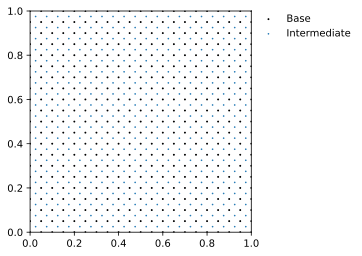

In [537]:
grid_plot(X, Y, X_stag, Y_stag, bounds=[(x_min, x_max), (y_min, y_max)])

Plot data

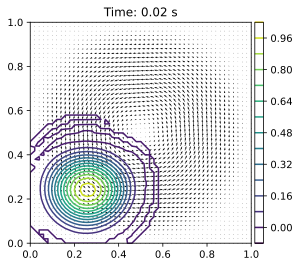

In [669]:
plot(X, Y, u, v, phi, times, t=2)

In [625]:
phi[:, :, 1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])